In [1]:
from glob import glob
import os
import mrpro.algorithms.csm
import torch
import h5py

In [77]:
import random
import torchvision

In [2]:
import matplotlib.pyplot as plt
%matplotlib widget

In [ ]:
pick_random_scans = random.sample(glob(f"/home/global/mri_datasets/fastmri/brain_multicoil_train/file_brain_AXT2_*.h5"), 3) + random.sample(glob(f"/home/global/mri_datasets/fastmri/brain_multicoil_train/file_brain_AXT1*.h5"), 5)
dataset_files = [h5py.File(file) for file in pick_random_scans]
smooth_width = 1

# Evaluation of reconstruction with csm

In [83]:
results = []
for dataset_file in dataset_files: 
    # reading the k-space data
    k_space_raw = torch.tensor(dataset_file["kspace"][:])
    # mrmpro.walsh expects data to be (coils, z, height (y), width (x))
    # since the slices are not lie on each other (not real z dimension)
    # we observe the slices individually
    # this results the shape of (slices, coils, 1, height, width)
    k_space = torch.unsqueeze(k_space_raw, 2)
    image_space = torch.fft.ifftshift(
        torch.fft.ifftn(
        torch.fft.fftshift(k_space, dim=(-1, -2)), dim=(-1, -2)), dim=(-1, -2))
    # evaluate for each slice in slices
    sl_list = [mrpro.algorithms.csm.walsh(sl, smooth_width) for sl in torch.unbind(image_space, 0)]
    # sensitivity maps for each slices (slices, coils, 1, height, width)
    sens_maps = torch.stack(sl_list, dim=0)
    # see mrpro.operators.SensitivityOp
    # applying the sensitivity maps to the image_space images
    # sum over coils and "1" dimension to obtain the normalized images
    # of shape (slices, height, width)
    result = torch.sum(sens_maps.conj()*image_space, dim=(1,2))
    results.append(result)

# Comparasion with the `reconstruction_rss` 

In [ ]:
rss_recons = []
for dataset_file in dataset_files:
    recon_rss = torch.tensor(dataset_file["reconstruction_rss"][:])
    # crop to square
    rss_recons.append(recon_rss)

/opt/conda/envs/RecoEnv311/lib/python3.11/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


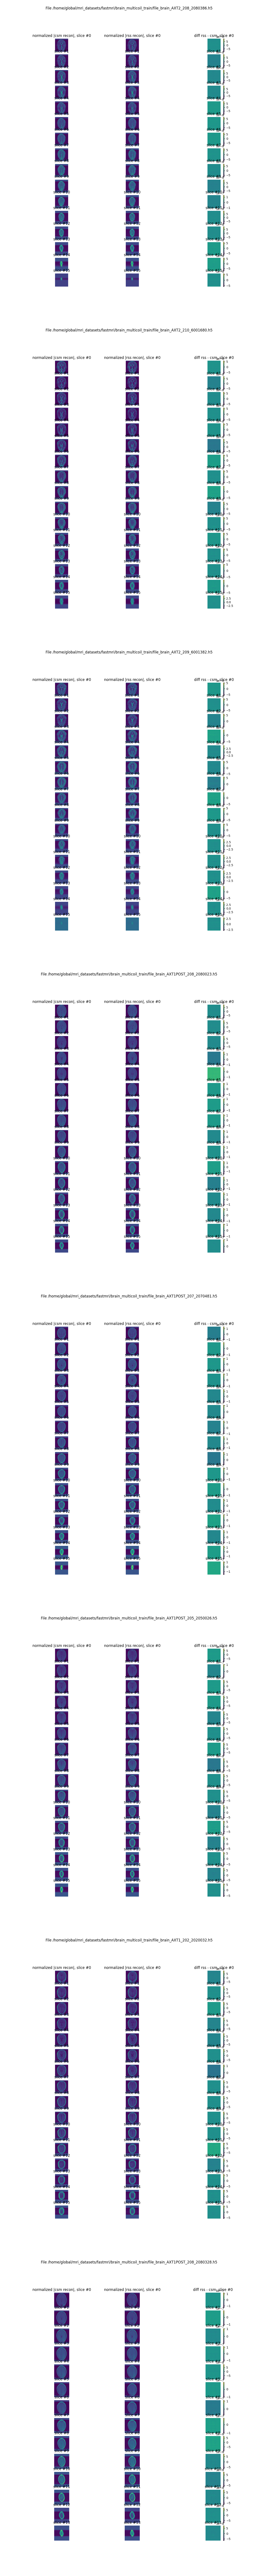

In [85]:
import torchvision.transforms.functional


fig = plt.figure(figsize=(12, 120))
subfigures = fig.subfigures(len(pick_random_scans))
for subfigure, filename, csm_result, rss_result in zip(subfigures, pick_random_scans, results, rss_recons):
    subfigure.suptitle(f"File {filename}")
    axs = subfigure.subplots(csm_result.shape[0], 3)
    for slice_nr, (csm_image, rss_image, ax_line) in enumerate(zip(csm_result, rss_result, axs)):
        # crop to middle
        
        crop_csm = torchvision.transforms.functional.center_crop(csm_image, rss_image.shape)
        
        abs_norm = lambda q: torch.nn.functional.normalize(q.abs())
        if slice_nr == 0:
            ax_line[0].set_title(f"normalized |csm recon|, slice #{slice_nr}")
            ax_line[1].set_title(f"normalized |rss recon|, slice #{slice_nr}")
            ax_line[2].set_title(f"diff rss - csm, slice #{slice_nr}")
        else:
            ax_line[0].set_title(f"slice #{slice_nr}")
            ax_line[1].set_title(f"slice #{slice_nr}")
            ax_line[2].set_title(f"slice #{slice_nr}")
        ax_line[0].imshow(abs_norm(crop_csm))
        ax_line[0].axis('off')
        
        ax_line[1].imshow(abs_norm(rss_image))
        ax_line[1].axis('off')
        
        im = ax_line[2].imshow(abs_norm(rss_image) - abs_norm(crop_csm))
        plt.colorbar(im, ax=ax_line[2])
        ax_line[2].axis('off')
fig.savefig("comparasion.pdf")

/opt/conda/envs/RecoEnv311/lib/python3.11/site-packages/traitlets/traitlets.py:1385: DeprecationWarning: Passing unrecognized arguments to super(Toolbar).__init__().
NavigationToolbar2WebAgg.__init__() missing 1 required positional argument: 'canvas'
This is deprecated in traitlets 4.2.This error will be raised in a future release of traitlets.
  warn(


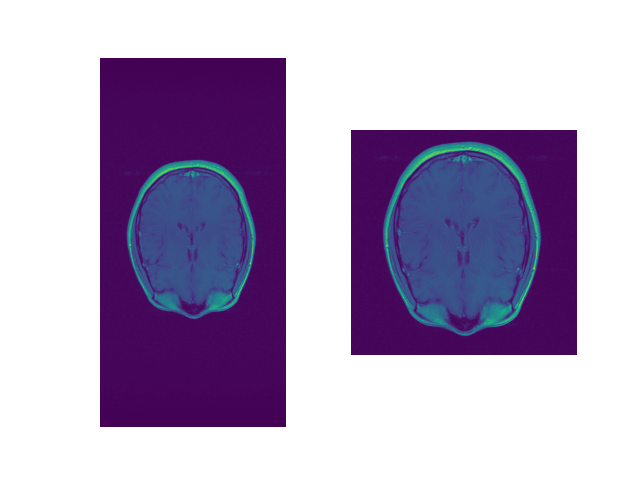

In [86]:
f = plt.figure()
axs = f.subplots(1, 2)
list(map(lambda ax: ax.axis('off'), axs))
axs[0].imshow(result[0].abs())
axs[1].imshow(recon_rss[0].abs())

In [87]:
print(f"RSS shape: {recon_rss.shape} and CSM shape: {result.shape}")

RSS shape: torch.Size([14, 320, 320]) and CSM shape: torch.Size([14, 640, 322])
